# Preliminary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
from tqdm import tqdm
from collections import defaultdict
from sklearn.cluster import KMeans
from tqdm import tqdm
from collections import defaultdict
from cop_kmeans import cop_kmeans
import itertools
from itertools import combinations
from matching import load_data

plt.rcParams['text.usetex'] = True

ModuleNotFoundError: No module named 'constants'

### Negative Log Bayes Factor

This was previously numerically inaccurate because the $\kappa_{(i,c)}$ in radians for the real data is on the order of $10^{13}$. However, we always take the $\log$ of those terms. So, we can utilize the following more numerically accurate calculation:

Let $\kappa_{(i,c)}$ be in $\text{arcseconds}^{-2}$. Then, to convert to $\text{rad}^{-2}$, we multiply by $C=\log((\pi/180/3600)^{-2})$. $C$ is the large number which makes the numerical calculations inaccurate. Then, we can use the following identities to keep all intermediate numbers small:
$$
\sum_{(i,c)\in O} \log(C\kappa_{(i,c)}) = \sum_{(i,c)\in O} (\log(C) + \log(\kappa_{(i,c)})) = |S_o|\log(C) +  \sum_{(i,c)\in O}\log(\kappa_{(i,c)}))
$$
$$
\log\left(\sum_{(i,c)\in O} C\kappa_{(i,c)}\right) = \log\left(C\sum_{(i,c)\in O} \kappa_{(i,c)}\right) = \log(C) + \log\left(\sum_{(i,c)\in O} \kappa_{(i,c)}\right)
$$

In [2]:
from matching import (
    run_cop_kmeans, 
    run_kmeans, 
    setup_dirilp, 
    dirilp, 
    find_max_clusters, 
    setup_miqcp_model, 
    neg_log_bayes,
    plot_lined,
    chain_breaking,
    miqcp
)

### Plot Methods

In [3]:
def plot_friends_of_friends(data_df):
    plt.figure(figsize=(7,7))
    plt.scatter(data_df['coord1 (arcseconds)'],
                data_df['coord2 (arcseconds)'],
                s=2.5, c = data_df.SubID, cmap='tab20')
    plt.title("Clustered via Single-Linkage\n"
                  r"$-\sum_{{o\in O}}\log(B_o)=$"
                  f"${neg_log_bayes(data_df, list(data_df.SubID)):.2f}$")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
def plot_cop_kmeans(data_df, num_repeat = 10):
    best_labels, best_k, best_bayes = run_cop_kmeans(data_df = data_df, min_k = 1, max_k = data_df.shape[0], num_repeat = num_repeat)

    plt.figure(figsize=(7,7))
    plt.scatter(data_df['coord1 (arcseconds)'],
                data_df['coord2 (arcseconds)'],
                s=2.0, c = best_labels, cmap='tab20')
    plt.title("COP K-Means\n"
              f"Best $k={best_k}$\n"
                  r"$-\sum_{{o\in O}}\log(B_o)=$"
                  f"${best_bayes:.2f}$")
    plt.xlabel("$x$ (arcseconds)")
    plt.ylabel("$y$ (arcseconds)")
    plt.show()
    
def plot_cop_kmeans_lined(data_df, num_repeat = 10):
    best_labels, best_k, best_bayes = run_cop_kmeans(data_df = data_df, min_k = 1, max_k = data_df.shape[0], num_repeat = num_repeat)
    plot_lined(best_labels, data_df)
    plt.title("COP K-Means\n"
              f"Best $k={best_k}$\n"
                  r"$-\sum_{{o\in O}}\log(B_o)=$"
                  f"${best_bayes:.2f}$")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
def plot_friends_of_friends_lined(data_df):
    labels = list(data_df.SubID)
    plot_lined(labels, data_df)
    plt.title("Chain-Breaking\n"
                  r"$-\sum_{{o\in O}}\log(B_o)=$"
                  f"${neg_log_bayes(data_df, list(data_df.SubID)):.2f}$")
    plt.xlabel("$x$ (arcseconds)")
    plt.ylabel("$y$ (arcseconds)")
    plt.show()
    
def plot_kmeans(data_df):
    best_labels, best_k, best_bayes = run_kmeans(data_df = data_df, min_k = 1, max_k = data_df.shape[0])

    plt.figure(figsize=(7,7))
    plt.scatter(data_df['coord1 (arcseconds)'],
                data_df['coord2 (arcseconds)'],
                s=2.0, c = best_labels, cmap='tab20')
    plt.title("Clustered via K-Means\n"
              f"Best $k={best_k}$\n"
                  r"$-\sum_{{o\in O}}\log(B_o)=$"
                  f"${best_bayes:.2f}$")
    plt.xlabel("$x$ (arcseconds)")
    plt.ylabel("$y$ (arcseconds)")
    plt.show()
    
def plot_kmeans_lined(data_df):
    best_labels, best_k, best_bayes = run_kmeans(data_df = data_df, min_k = 1, max_k = data_df.shape[0])
    plot_lined(best_labels, data_df)
    plt.title("Clustered via K-Means\n"
              f"Best $k={best_k}$\n"
                  r"$-\sum_{{o\in O}}\log(B_o)=$"
                  f"${best_bayes:.2f}$")
    plt.xlabel("$x$ (arcseconds)")
    plt.ylabel("$y$ (arcseconds)")
    plt.show()
    
def plot_miqcp(data_df, max_clusters = -1):
    labels = miqcp(data_df, max_clusters)
    plt.figure(figsize=(7,7))
    plt.scatter(data_df['coord1 (arcseconds)'],
                data_df['coord2 (arcseconds)'],
                s=2.0, c = labels, cmap='tab10')
    plt.title("Clustered via MIQCP\n"
                r"$-\sum_{{o\in O}}\log(B_o)=$"
                f"${neg_log_bayes(data_df, labels):.2f}$")
    plt.xlabel("$x$ (arcseconds)")
    plt.ylabel("$y$ (arcseconds)")
    plt.show()

## Load medium-size data

In [6]:
data_df = load_data('data/match_4000710334517.csv')
data_df

,MatchID,SubID,RA,Dec,ImageID,SourceID,X,Y,Z,Sigma,kappa,kappa (radians),log kappa (radians),coord1 (arcseconds),coord2 (arcseconds)
0,4000710334517,0,269.749758,-29.186608,0,0,-0.003813,-0.873028,-0.487656,0.024100,1721.682560,7.324928e+13,31.924890,-0.720352,0.002771
1,4000710334517,0,269.749758,-29.186608,1,1,-0.003814,-0.873028,-0.487656,0.042233,560.647048,2.385282e+13,30.802924,-0.534686,0.042572
2,4000710334517,0,269.749758,-29.186608,1,2,-0.003812,-0.873028,-0.487656,0.025386,1551.695135,6.601713e+13,31.820935,-0.880725,0.090439
3,4000710334517,0,269.749758,-29.186608,2,3,-0.003813,-0.873028,-0.487656,0.022386,1995.484155,8.489821e+13,32.072474,-0.736634,0.101140
4,4000710334517,0,269.749758,-29.186608,3,4,-0.003813,-0.873028,-0.487656,0.010583,8928.484566,3.798639e+14,33.570834,-0.726180,0.094178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,4000710334517,7,269.749189,-29.186707,63,420,-0.003822,-0.873027,-0.487657,0.006594,23000.000000,9.785389e+14,34.517082,1.098400,-0.270365
421,4000710334517,7,269.749189,-29.186707,75,421,-0.003822,-0.873027,-0.487657,0.006594,23000.000000,9.785389e+14,34.517082,1.111520,-0.242199
422,4000710334517,7,269.749189,-29.186707,79,422,-0.003822,-0.873027,-0.487657,0.033464,893.008876,3.799321e+13,31.268429,1.156522,-0.251002
423,4000710334517,7,269.749189,-29.186707,82,423,-0.003822,-0.873027,-0.487657,0.006594,23000.000000,9.785389e+14,34.517082,1.089730,-0.207292


### Chain-Breaking

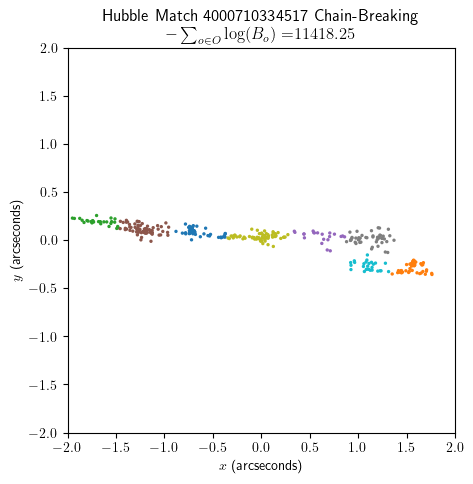

In [35]:
plt.figure(figsize=(5,5))
plt.scatter(data_df['coord1 (arcseconds)'],
            data_df['coord2 (arcseconds)'],
            s=2.0, c = data_df.SubID, cmap='tab10')
plt.title("Hubble Match 4000710334517 Chain-Breaking\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${neg_log_bayes(data_df, data_df.SubID):.2f}$")
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.savefig("figures/presentation/hubble_chain-breaking_medium.svg")

### KMeans

100%|██████████| 49/49 [02:35<00:00,  3.17s/it]


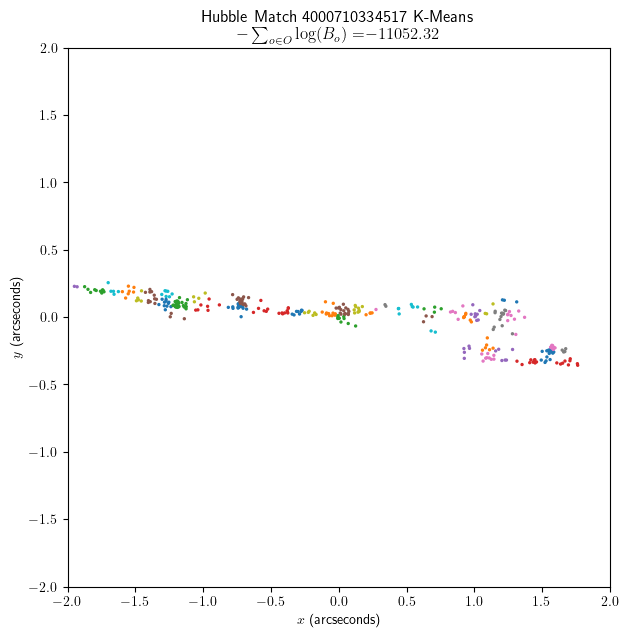

In [12]:
best_labels, _, _ = run_kmeans(data_df, 1,50)

plt.figure(figsize=(5,5))
plt.scatter(data_df['coord1 (arcseconds)'],
            data_df['coord2 (arcseconds)'],
            s=2.0, c = best_labels, cmap='tab10')
plt.title("Hubble Match 4000710334517 K-Means\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${neg_log_bayes(data_df, best_labels):.2f}$")
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.savefig("figures/presentation/hubble_kmeans_medium.svg")

### COP-KMeans

61


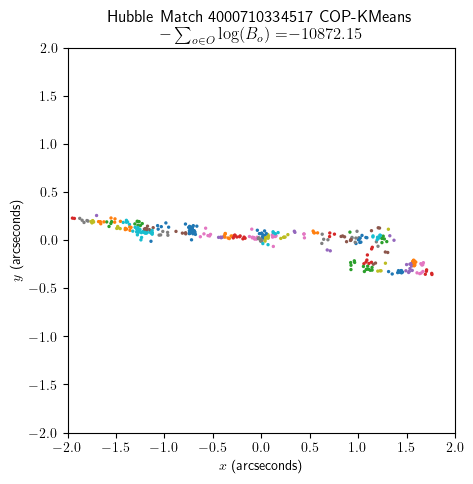

In [39]:
best_labels, best_k, _ = run_cop_kmeans(data_df, 1, data_df.shape[0] // 5)
print(best_k)
plt.figure(figsize=(5,5))
plt.scatter(data_df['coord1 (arcseconds)'],
            data_df['coord2 (arcseconds)'],
            s=2.0, c = best_labels, cmap='tab10')
plt.title("Hubble Match 4000710334517 COP-KMeans\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${neg_log_bayes(data_df, best_labels):.2f}$")
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.savefig("figures/presentation/hubble_cop-kmeans_medium.svg")

## Big Data

In [14]:
big_data_path = "big_data/MyHDF_jacobf18_0.csv"
big_data_df = pd.read_csv(big_data_path)

# Convert Image IDs to integers in range [0, number of images]
big_data_df.ImageID = pd.factorize(big_data_df.ImageID)[0]

# Get kappas (inverse of sigma)
big_data_df["kappa"] = 1 / (big_data_df.Sigma ** 2)
big_data_df["kappa (radians)"] = 1 / ((big_data_df.Sigma*np.pi/180/3600) ** 2)
big_data_df["log kappa (radians)"] = np.log(big_data_df["kappa (radians)"])

# Get center of data points
center_ra = big_data_df.RA.mean()
center_dec = big_data_df.Dec.mean()

center_west, center_north = tangent(center_ra, center_dec)

big_data_df["coord1 (arcseconds)"] = (big_data_df[["X", "Y", "Z"]] @ center_west) * 180 * 3600 / np.pi
big_data_df["coord2 (arcseconds)"] = (big_data_df[["X", "Y", "Z"]] @ center_north) * 180 * 3600 / np.pi

big_data_df

,ImageID,JobID,MatchID,SourceID,X,Y,Z,Sigma,RA,Dec,kappa,kappa (radians),log kappa (radians),coord1 (arcseconds),coord2 (arcseconds)
0,0,35306,4211611957,4000916189528,0.456528,-0.182370,-0.870817,0.02900,338.225364,-60.552930,1189.060564,5.058878e+13,31.554751,10.930064,-5.757109
1,0,35306,4211611904,4000916189529,0.456427,-0.182594,-0.870823,0.01000,338.196765,-60.553629,10000.000000,4.254517e+14,33.684173,61.544402,-8.301104
2,0,35306,4211611842,4000916189530,0.456499,-0.182411,-0.870824,0.01875,338.219733,-60.553715,2844.444444,1.210174e+14,32.426955,20.895535,-8.587093
3,0,35306,4211611919,4000916189532,0.456505,-0.182411,-0.870821,0.01110,338.219887,-60.553379,8116.224123,3.453061e+14,33.475452,20.623653,-7.377742
4,0,35306,4211612082,4000916189535,0.456455,-0.182547,-0.870819,0.02810,338.203047,-60.553056,1266.448045,5.388125e+13,31.617804,50.428467,-6.230797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60500,55,35306,4600995538,4600995538,0.456473,-0.182048,-0.870914,0.10680,338.256965,-60.564915,87.671305,3.729991e+12,28.947427,-46.624523,-46.174268
60501,55,35306,4600995523,4600995523,0.456340,-0.182410,-0.870908,0.02490,338.211995,-60.564248,1612.877199,6.862014e+13,31.859607,32.937911,-43.786583
60502,55,35306,4600995488,4600995488,0.456445,-0.182132,-0.870911,0.07570,338.246640,-60.564574,174.505139,7.424351e+12,29.635786,-28.356915,-44.944932
60503,55,35306,4600995480,4600995480,0.456368,-0.182323,-0.870911,0.14380,338.222590,-60.564618,48.359547,2.057465e+12,28.352496,14.191576,-45.110163


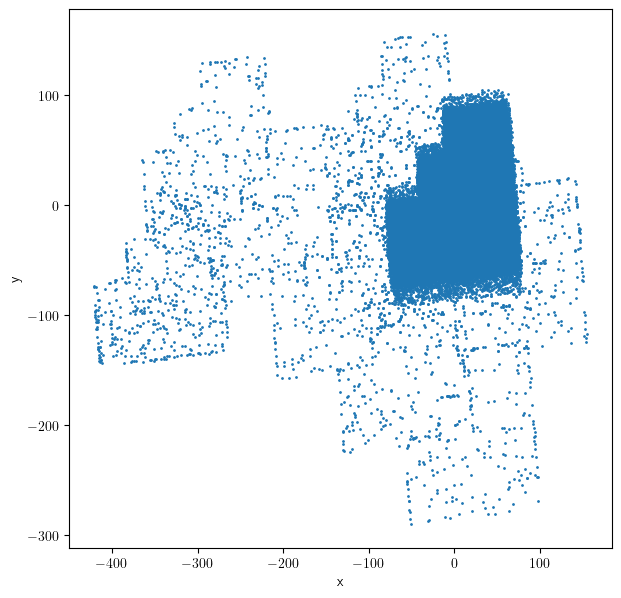

In [15]:
plt.figure(figsize=(7,7))
plt.scatter(big_data_df['coord1 (arcseconds)'],
            big_data_df['coord2 (arcseconds)'],
            s=1.0)
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.show()

100%|██████████| 1/1 [02:55<00:00, 175.12s/it]


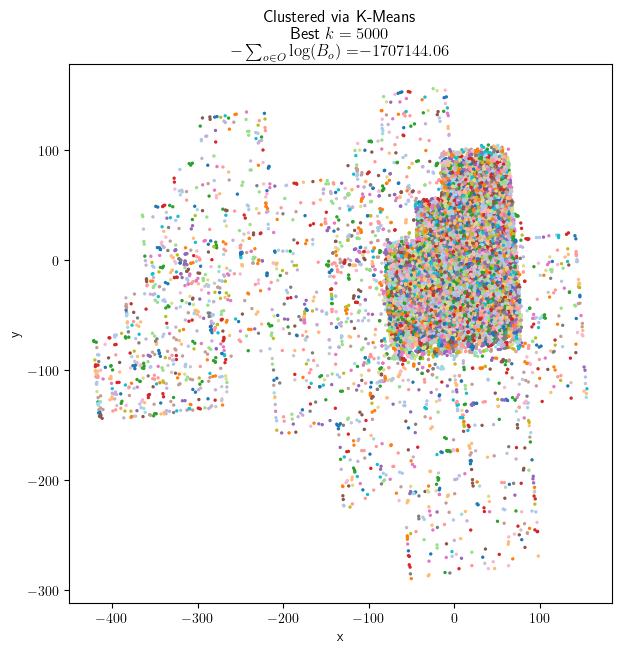

In [16]:
from sklearn.cluster import KMeans
from tqdm import tqdm

best_labels = None
best_k = 0
best_bayes = np.Inf

coords = big_data_df[["coord1 (arcseconds)", "coord2 (arcseconds)"]]
weights = big_data_df["kappa"]

for k in tqdm(range(5000,5001)):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X = coords, sample_weight=weights)

    bayes = neg_log_bayes(big_data_df, kmeans.labels_)

    if bayes < best_bayes:
        best_bayes = bayes
        best_labels = kmeans.labels_
        best_k = k

plt.figure(figsize=(7,7))
plt.scatter(big_data_df['coord1 (arcseconds)'],
            big_data_df['coord2 (arcseconds)'],
            s=2.0, c = best_labels, cmap='tab20')
plt.title("Clustered via K-Means\n"
          f"$k={best_k}$\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${best_bayes:.2f}$")
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.show()

In [64]:
image_ra_dec = big_data_df.groupby(['ImageID'])[["X", "Y", "Z"]].mean()

image_ra_dec["coord1 (arcseconds)"] = (image_ra_dec[["X", "Y", "Z"]] @ center_west) * 180 * 3600 / np.pi
image_ra_dec["coord2 (arcseconds)"] = (image_ra_dec[["X", "Y", "Z"]] @ center_north) * 180 * 3600 / np.pi

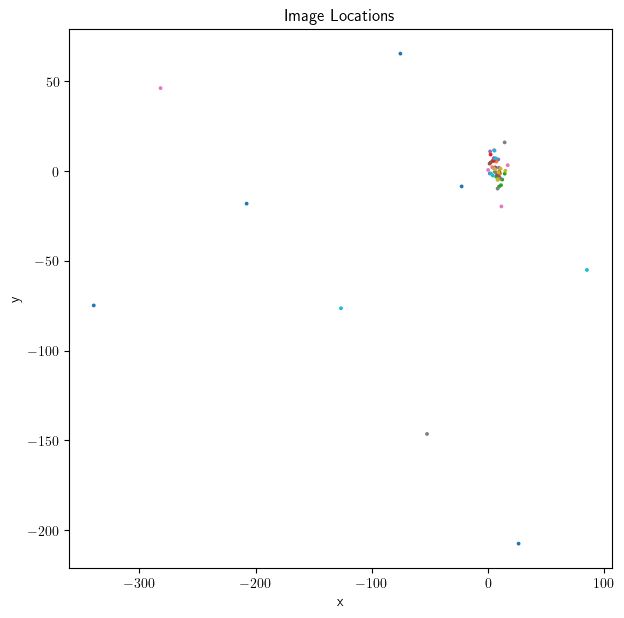

In [68]:
plt.figure(figsize=(7,7))
plt.scatter(image_ra_dec['coord1 (arcseconds)'],
            image_ra_dec['coord2 (arcseconds)'],
            s=3.0, c = image_ra_dec.index, cmap='tab10')
plt.title("Image Locations")
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.show()

In [56]:
import faiss
d = 2 # number of features
ncentroids = 5000

kmeans = faiss.Kmeans(d, ncentroids, niter = 300, verbose = False, gpu = True, nredo = 1)

kmeans.train(coords,weights)

_, labels = kmeans.index.search(coords,1)

neg_log_bayes(big_data_df, list(labels.flatten()))

WARNING clustering 60505 points to 5000 centroids: please provide at least 195000 training points


-1650102.431649264

### COP-Kmeans

In [ ]:
best_labels, best_k, best_bayes = run_cop_kmeans(big_data_df, 100,101)

plt.figure(figsize=(7,7))
plt.scatter(big_data_df['coord1 (arcseconds)'],
            big_data_df['coord2 (arcseconds)'],
            s=2.0, c = best_labels, cmap='tab20')
plt.title("Clustered via K-Means\n"
          f"Best $k={best_k}$\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${best_bayes:.2f}$")
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.show()

## Match 6000160767697 - Small Data

In [4]:
data_df_2 = load_data("data/match_6000160767697.csv")
data_df_2

,MatchID,Level,SubID,ImageID,SourceID,X,Y,Z,Sigma,RA,Dec,kappa,kappa (radians),log kappa (radians),coord1 (arcseconds),coord2 (arcseconds)
0,6000160767697,2,0,0,0,-0.770668,-0.025419,-0.63673,0.017658,181.889145,-39.548367,3207.057265,1.364448e+14,32.546941,0.057720,-0.070164
1,6000160767697,2,0,1,1,-0.770668,-0.025419,-0.63673,0.018430,181.889145,-39.548367,2944.178745,1.252606e+14,32.461417,0.054930,-0.066913
2,6000160767697,2,0,2,2,-0.770668,-0.025419,-0.63673,0.018430,181.889097,-39.548468,2944.178745,1.252606e+14,32.461417,0.062785,-0.071690
3,6000160767697,2,0,3,3,-0.770668,-0.025419,-0.63673,0.018773,181.889097,-39.548466,2837.611131,1.207266e+14,32.424550,0.063094,-0.073348
4,6000160767697,2,0,4,4,-0.770668,-0.025419,-0.63673,0.021173,181.889148,-39.548365,2230.731063,9.490683e+13,32.183917,0.055842,-0.069751
5,6000160767697,2,0,5,5,-0.770668,-0.025419,-0.63673,0.019287,181.889099,-39.548469,2688.289868,1.143738e+14,32.370493,0.063280,-0.071242
6,6000160767697,2,1,6,6,-0.770668,-0.025420,-0.63673,0.005460,181.889168,-39.548429,33548.042958,1.427307e+15,34.894566,-0.115376,-0.009996
7,6000160767697,2,1,7,7,-0.770668,-0.025420,-0.63673,0.005301,181.889172,-39.548426,35580.802793,1.513791e+15,34.953394,-0.116995,-0.009337
8,6000160767697,2,1,8,8,-0.770668,-0.025420,-0.63673,0.005723,181.889163,-39.548418,30527.297223,1.298789e+15,34.800209,-0.116098,-0.011518
9,6000160767697,2,1,9,9,-0.770668,-0.025420,-0.63673,0.009706,181.889189,-39.548406,10614.809397,4.516089e+14,33.743838,-0.085463,-0.034497


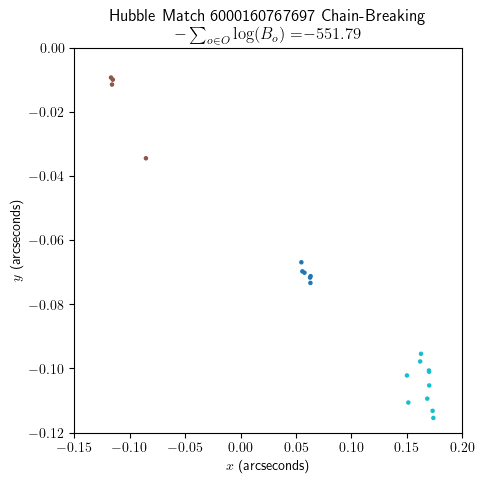

In [8]:
plt.figure(figsize=(5,5))
plt.scatter(data_df_2['coord1 (arcseconds)'],
            data_df_2['coord2 (arcseconds)'],
            s=5.0, c = data_df_2.SubID, cmap='tab10')
plt.title("Hubble Match 6000160767697 Chain-Breaking\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${neg_log_bayes(data_df_2, data_df_2.SubID):.2f}$")
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
plt.xlim([-0.15,0.2])
plt.ylim([-0.12,0])
plt.savefig("figures/presentation/hubble_chain-breaking_small.svg")

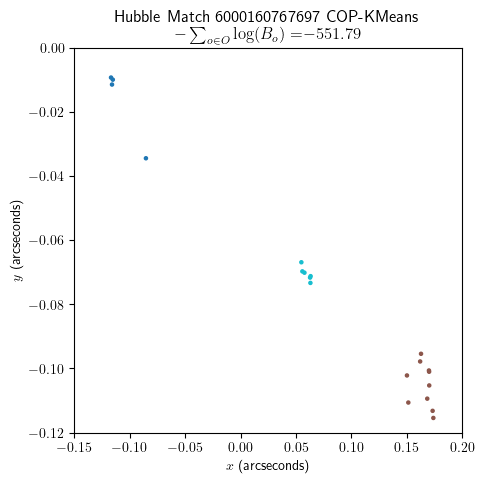

In [9]:
best_labels, _, _ = run_cop_kmeans(data_df_2, 1, data_df_2.shape[0])

plt.figure(figsize=(5,5))
plt.scatter(data_df_2['coord1 (arcseconds)'],
            data_df_2['coord2 (arcseconds)'],
            s=5.0, c = best_labels, cmap='tab10')
plt.title("Hubble Match 6000160767697 COP-KMeans\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${neg_log_bayes(data_df_2, best_labels):.2f}$")
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
plt.xlim([-0.15,0.2])
plt.ylim([-0.12,0])
plt.savefig("figures/presentation/hubble_cop-kmeans_small.svg")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-06


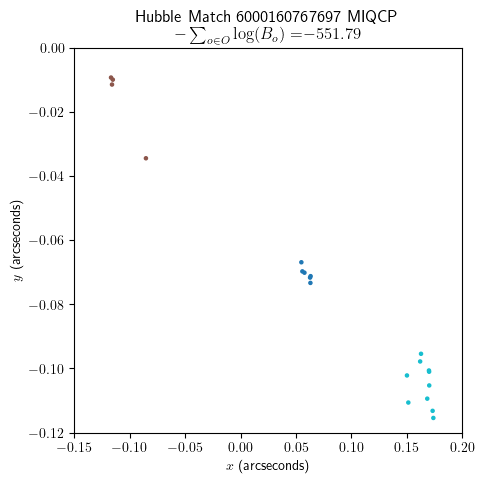

In [5]:
labels = miqcp(data_df_2, verbose = False, preDual = False, preQLinearize=False)

plt.figure(figsize=(5,5))
plt.scatter(data_df_2['coord1 (arcseconds)'],
            data_df_2['coord2 (arcseconds)'],
            s=5.0, c = labels, cmap='tab10')
plt.title("Hubble Match 6000160767697 MIQCP\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${neg_log_bayes(data_df_2, labels):.2f}$")
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
plt.xlim([-0.15,0.2])
plt.ylim([-0.12,0])
plt.savefig("figures/presentation/hubble_miqcp_small.svg")

## Match 6000204755575

In [7]:
data_df_3 = load_data("data/match_6000204755575.csv")
data_df_3

,MatchID,Level,SubID,ImageID,SourceID,X,Y,Z,Sigma,RA,Dec,kappa,kappa (radians),log kappa (radians),coord1 (arcseconds),coord2 (arcseconds)
0,6000204755575,17,0,0,0,-0.609245,0.584830,-0.535532,0.018014,136.171340,-32.379990,3081.530394,1.311042e+14,32.507014,-0.462566,0.322374
1,6000204755575,17,0,1,1,-0.609245,0.584830,-0.535532,0.014955,136.171300,-32.379949,4471.381482,1.902357e+14,32.879285,-0.339688,0.301519
2,6000204755575,17,1,0,2,-0.609240,0.584834,-0.535532,0.009284,136.170901,-32.380026,11601.724041,4.935973e+14,33.832741,0.873614,0.193737
3,6000204755575,17,2,0,3,-0.609241,0.584831,-0.535535,0.013135,136.171105,-32.380175,5796.277435,2.466036e+14,33.138803,0.254267,-0.342248
4,6000204755575,17,3,0,4,-0.609244,0.584829,-0.535535,0.019333,136.171353,-32.380182,2675.468937,1.138283e+14,32.365712,-0.500021,-0.368822
5,6000204755575,17,4,0,5,-0.609243,0.584832,-0.535532,0.024001,136.171126,-32.379984,1735.901316,7.385422e+13,31.933114,0.189571,0.345358
6,6000204755575,17,5,2,6,-0.609243,0.584830,-0.535534,0.023184,136.171246,-32.380112,1860.501853,7.915537e+13,32.002434,-0.153061,-0.114746
7,6000204755575,17,5,1,7,-0.609243,0.584830,-0.535534,0.011579,136.171266,-32.380063,7458.969637,3.173431e+14,33.391005,-0.235482,-0.106740
8,6000204755575,17,5,1,8,-0.609243,0.584830,-0.535534,0.006620,136.171208,-32.380078,22817.098315,9.707573e+14,34.509098,-0.059766,-0.163652
9,6000204755575,17,5,3,9,-0.609243,0.584830,-0.535534,0.015219,136.171321,-32.380213,4317.737444,1.836989e+14,32.844319,-0.180112,-0.221155


In [8]:
def plot_lined(labels, data_df):
    loc_tups = [(row["coord1 (arcseconds)"], row["coord2 (arcseconds)"]) for _, row in data_df.iterrows()]

    label_dict = defaultdict(list)
    for tup, label in zip(loc_tups, labels):
        label_dict[label].append(tup)
        
    for label, tup_list in label_dict.items():
        if len(tup_list) == 1:
            pairs = [tup_list]
        else:
            pairs = list(itertools.combinations(tup_list, 2))
        for pair in pairs:
            x = []
            y = []
            for tup in pair:
                x.append(tup[0])
                y.append(tup[1])
            plt.plot(x, y, color='green', marker='o', linestyle='-', linewidth=1, markersize=2)

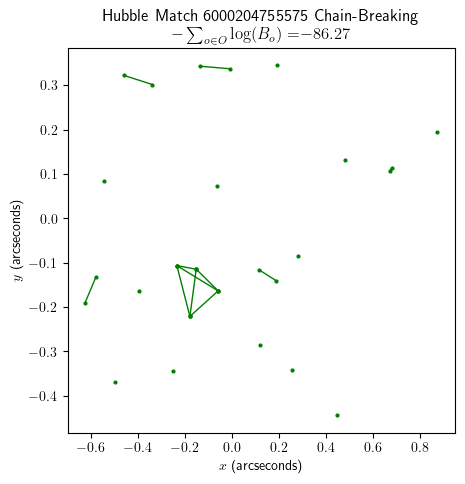

In [9]:
plt.figure(figsize=(5,5))
plot_lined(data_df_3.SubID, data_df_3)
plt.title("Hubble Match 6000204755575 Chain-Breaking\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${neg_log_bayes(data_df_3, data_df_3.SubID):.2f}$")
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
# plt.xlim([-0.2,0.2])
# plt.ylim([-0.15,0])
plt.savefig("figures/presentation/hubble_chain-breaking_medium2.svg")

100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


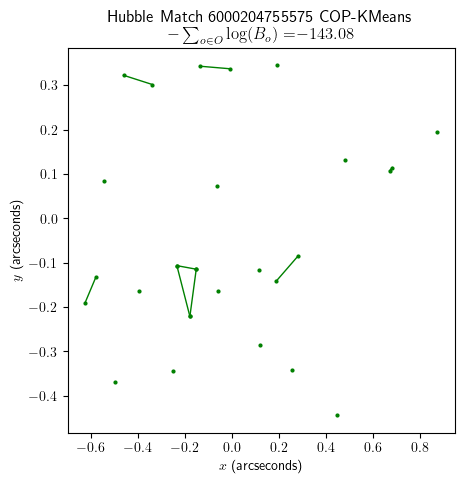

In [10]:
best_labels,_,_ = run_cop_kmeans(data_df_3, 1, data_df_3.shape[0], num_repeat=5, verbose=True)

plt.figure(figsize=(5,5))
plot_lined(best_labels, data_df_3)
plt.title("Hubble Match 6000204755575 COP-KMeans\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${neg_log_bayes(data_df_3, best_labels):.2f}$")
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
# plt.xlim([-0.2,0.2])
# plt.ylim([-0.15,0])
plt.savefig("figures/presentation/hubble_cop-kmeans_medium2.svg")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-06
Max Clusters using COP-KMeans: 24
Set parameter OutputFlag to value 1
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 988 rows, 962 columns and 4345 nonzeros
Model fingerprint: 0x139c956c
Model has 624 quadratic constraints
Variable types: 122 continuous, 840 integer (816 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+04]
  QMatrix range    [2e+03, 4e+04]
  QLMatrix range   [1e+00, 6e+04]
  Objective range  [5e-01, 3e+01]
  Bounds range     [8e-01, 1e+00]
  RHS range        [3e-01, 1e+00]
  QRHS range       [5e+04, 6e+04]
Presolve removed 30 rows and 38 columns
Presolve time: 0.01s
Presolved: 958 rows, 924 columns, 5493 nonzeros
Presolved model has 24 quadratic constraint(s)
Variable typ

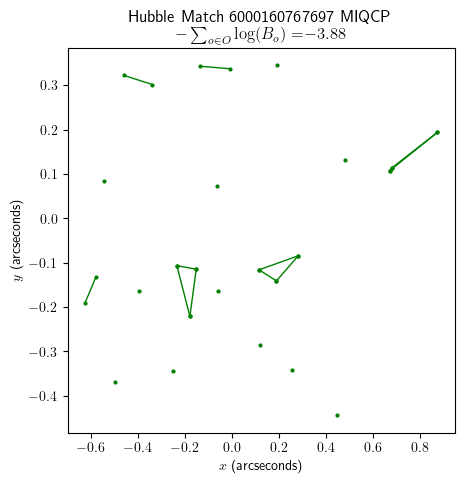

In [8]:
best_labels = miqcp(data_df_3, verbose=True, preDual=False,preQLinearize=False)

plt.figure(figsize=(5,5))
plot_lined(best_labels, data_df_3)
plt.title("Hubble Match 6000204755575 MIQCP\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${neg_log_bayes(data_df_3, best_labels):.2f}$")
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
# plt.xlim([-0.2,0.2])
# plt.ylim([-0.15,0])
plt.savefig("figures/presentation/hubble_miqcp_medium2.svg")

In [ ]:
from typing import Union

def log_runtimes(filename: str,
                 distances: Union[list[float], float], 
                 num_cats: Union[list[float], float], 
                 sigma1s: Union[list[float], float], 
                 sigma2s: Union[list[float], float],
                 repeats: int):
    pd_dict = {
        "distance": [],
        "number of catalogs": [],
        "sigma 1": [],
        "sigma 2": [],
        "runtimes": []
    }
    if type(distances) == float:
        distances = [distances]
    if type(num_cats) == float:
        num_cats = [num_cats]
    if type(sigma1s) == float:
        sigma1s = [sigma1s]
    if type(sigma2s) == float:
        sigma2s = [sigma2s]
    for d, n, s1, s2 in itertools.product(distances,num_cats,sigma1s,sigma2s):
        print(d,n,s1,s2)
        pd_dict["distance"].append(d)
        pd_dict["number of catalogs"].append(n)
        pd_dict["sigma 1"].append(s1)
        pd_dict["sigma 2"].append(s2)
        times = []
        for _ in range(repeats):
            df = simulate_two_objects(sigma1 = s1, sigma2 = s2, distance=d, num=n)
            miqcp_times = time_method(df, miqcp, repeat = 1)
            times.append(miqcp_times[0])
        pd_dict["runtimes"].append(times)
    
    df_times = pd.DataFrame(pd_dict)
    df_times.to_csv(filename)

log_runtimes("runtimes.csv", 0.075, [2, 5, 10, 15, 20, 25, 30, 35, 40], 0.02, 0.02, 5)

0.05 2 0.01 0.01
0.05 5 0.01 0.01
0.05 10 0.01 0.01
0.05 15 0.01 0.01
0.05 20 0.01 0.01
